In [1]:
import rasterio

# Load elevation data from 'sudamerica.tif'
elevation_dataset = rasterio.open("sudamerica.tif")

mosaic = elevation_dataset.read()
out_trans = elevation_dataset.transform

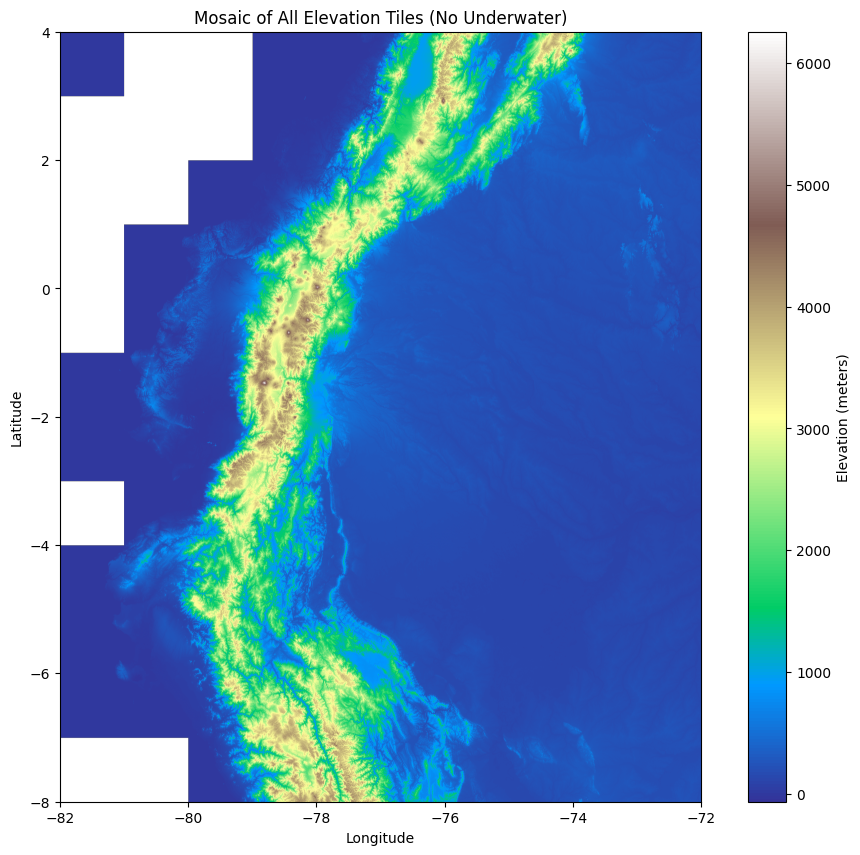

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Mask underwater (negative elevation) values
mosaic_masked = np.ma.masked_less(mosaic[0], -100)  # min in range is -67

plt.figure(figsize=(12, 10))

plt.imshow(
    mosaic_masked,
    cmap="terrain",
    extent=[
        out_trans.c,
        out_trans.c + out_trans.a * mosaic.shape[2],
        out_trans.f + out_trans.e * mosaic.shape[1],
        out_trans.f,
    ],
    origin="upper",
)

plt.colorbar(label="Elevation (meters)")

plt.title("Mosaic of All Elevation Tiles (No Underwater)")

plt.xlabel("Longitude")

plt.ylabel("Latitude")

plt.show()

In [10]:
mosaic.shape

(1, 14401, 12001)

In [14]:
14401 * 12001

172826401

In [11]:
700_000 / mosaic.shape[1]  # every 50m

48.607735573918475

In [25]:
n = 20
(mosaic.shape[1] // n) * (mosaic.shape[2] // n)

432000

In [29]:
lat_lims = (-5, 2)
lon_lims = (-81.5, -74.9)
# Calculate the row and column indices corresponding to the latitude and longitude limits
row_start = int((out_trans.f - lat_lims[1]) / abs(out_trans.e))
row_end = int((out_trans.f - lat_lims[0]) / abs(out_trans.e))
col_start = int(
    (lat_lims[0] - out_trans.c) / out_trans.a
)  # This is incorrect, should use lon_lims
col_start = int((lon_lims[0] - out_trans.c) / out_trans.a)
col_end = int((lon_lims[1] - out_trans.c) / out_trans.a)

# Slice the mosaic and mask to the specified lat/lon range
mosaic_masked_2 = mosaic_masked[row_start:row_end, col_start:col_end]

In [33]:
mosaic_masked_2.shape

(8400, 7920)

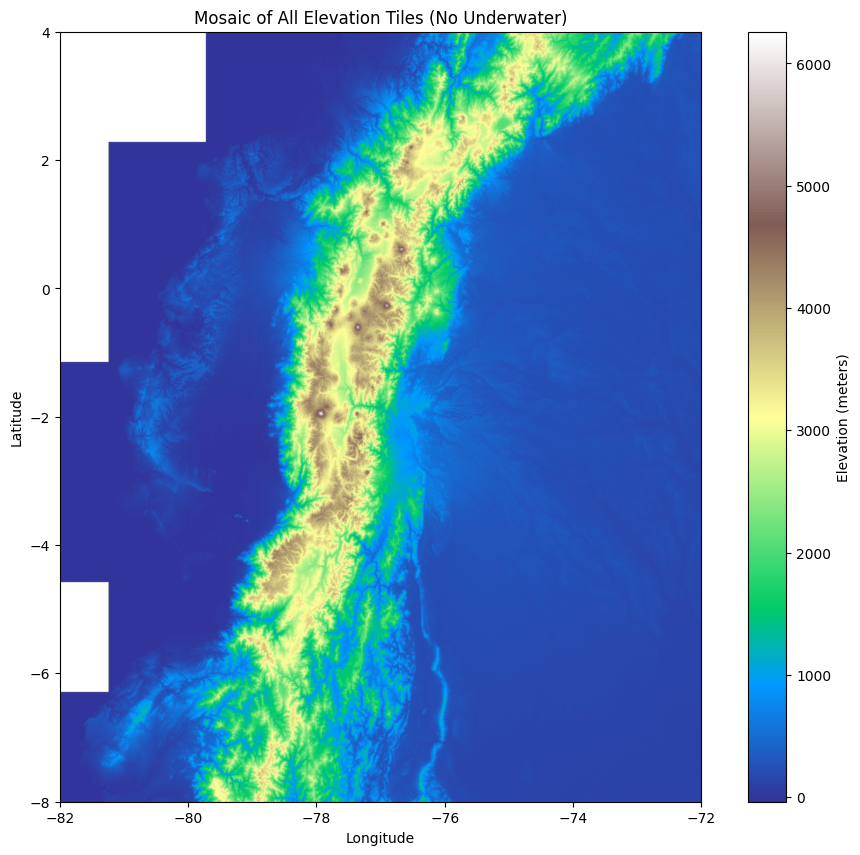

In [30]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

plt.imshow(
    mosaic_masked_2,
    cmap="terrain",
    extent=[
        out_trans.c,
        out_trans.c + out_trans.a * mosaic.shape[2],
        out_trans.f + out_trans.e * mosaic.shape[1],
        out_trans.f,
    ],
    origin="upper",
)

plt.colorbar(label="Elevation (meters)")

plt.title("Mosaic of All Elevation Tiles (No Underwater)")

plt.xlabel("Longitude")

plt.ylabel("Latitude")

plt.show()

In [53]:
def lats_longs():
    # Create an iterator of (latitude, longitude, elevation) for valid elevation data points within limits
    rows, cols = np.where(~mosaic_masked_2.mask)
    # Take every 20th point using slicing instead of enumerate+modulo
    for r, c in zip(rows[::2000], cols[::2000]):
        lon = out_trans.c + out_trans.a * c
        lat = out_trans.f + out_trans.e * r
        elev = mosaic_masked_2[r, c]
        yield (lat, lon, elev)

In [37]:
# a 20
points = list(lats_longs())
len(points)

3110428

In [41]:
3110428 / 10 / 10

31104.28

In [42]:
31104**0.5

176.36326148038881

In [54]:
points = list(lats_longs())
len(points)

31105

In [43]:
176 / 6

29.333333333333332

In [5]:
import requests


def get_location_info(lat, lon):
    # Prepare API URL
    url = f"https://nominatim.openstreetmap.org/reverse?lat={lat}&lon={lon}&format=json"

    # Make the API request
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    data = response.json()

    # Extract country and plot
    country = data.get("address", {}).get("country", "NA")
    state = data.get("address", {}).get("state", "NA")

    return data, country, state

In [ ]:
import winsound

winsound.Beep(1000, 3000)

In [59]:
from tqdm import tqdm

results = []
for lat, lon, elev in tqdm(points, desc="Processing points"):
    # for lat, lon, elev in tqdm(lats_longs(), desc="Processing points"):
    try:
        data, country, state = get_location_info(lat, lon)
    except Exception as e:
        print(f"Error fetching data for lat={lat}, lon={lon}: {e}")
        continue

    results.append(
        {
            "data": data,
            "lat": float(lat),
            "lon": float(lon),
            "country": country,
            "state": state,
            "elevation": float(elev),
        }
    )

Processing points:   0%|          | 32/31105 [03:13<52:11:02,  6.05s/it]


KeyboardInterrupt: 

In [ ]:
import json

with open("results.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)